In [246]:
import librosa
import numpy as np
from scipy.signal import convolve, deconvolve
import matplotlib.pyplot as plt
import pyloudnorm
import soundfile

In [247]:
def rms(signal):
    return np.sqrt(np.mean(signal **2))
def peak(signal):
    return np.max(np.abs(signal))
def loudness(signal, sr):
    meter = pyloudnorm.Meter(sr)
    return meter.integrated_loudness(signal)

In [248]:
def normalised(signal, mode, based_on_signal, sr=None):
    if mode == 'rms':
        scaling_factor = rms(based_on_signal)/rms(signal)
        return signal * scaling_factor
    elif mode == 'peak':
        scaling_factor = peak(based_on_signal)/peak(signal)
        return signal * scaling_factor
    elif mode == 'loudness':
        meter = pyloudnorm.Meter(sr)
        target_loudness = meter.integrated_loudness(based_on_signal)
        raw_loudness = meter.integrated_loudness(signal)
        return pyloudnorm.normalize.loudness(signal, raw_loudness, target_loudness)
    elif mode == 'none':
        return signal
    else:
        raise ValueError('invalid mode')
    
    

In [249]:
def apply_impulse_response(signal, impulse_response):
    return convolve(dry_signal, impulse_response)

In [265]:
# Function to plot an audio signal
def plot_signal(signal, title, sr=22050, label=None, start=0, length=None):
    length = len(signal) if length is None else length
    sig = signal[start:start+length]
    plt.plot(np.linspace(0, len(sig) / sr, num=len(sig)), sig, label=label)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()

In [292]:
def compare_signals(sig1, sig2, title1, title2, sr, start=0, length=None):
    # Adjust the length of the dry-transformed signal to match the target signal
    if len(sig1) > len(sig2):
        sig1 = sig1[:len(sig2)]
    else:
        sig2 = sig2[:len(sig1)]

    difference = sig1-sig2

    # Plot the 2 signals
    plt.subplot(2, 1, 1)
    plot_signal(sig1, title1, sr, label=title1, start=start, length=length)
    plt.legend()
    plot_signal(sig2, title2, sr, label=title2, start=start, length=length)
    plt.legend()
    
    # Plot the difference signal
    plt.subplot(2, 1, 2)
    plot_signal(difference, 'Difference Signal', sr, start=start, length=length)



In [267]:
# Load the audio files
dry_signal, sr = librosa.load('Eastman piezo 0009 [2023-12-30 162118].aif', sr=None)
target_signal, _ = librosa.load('Eastman mic 0009 [2023-12-30 162118].aif', sr=None)


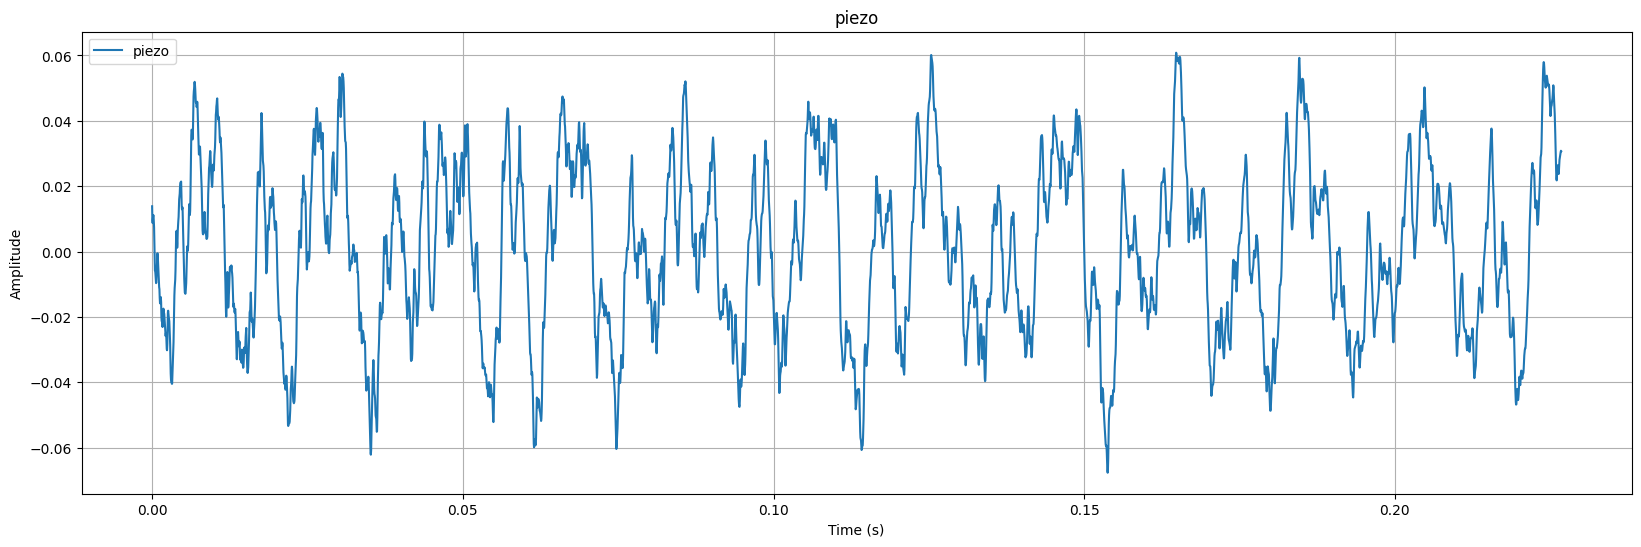

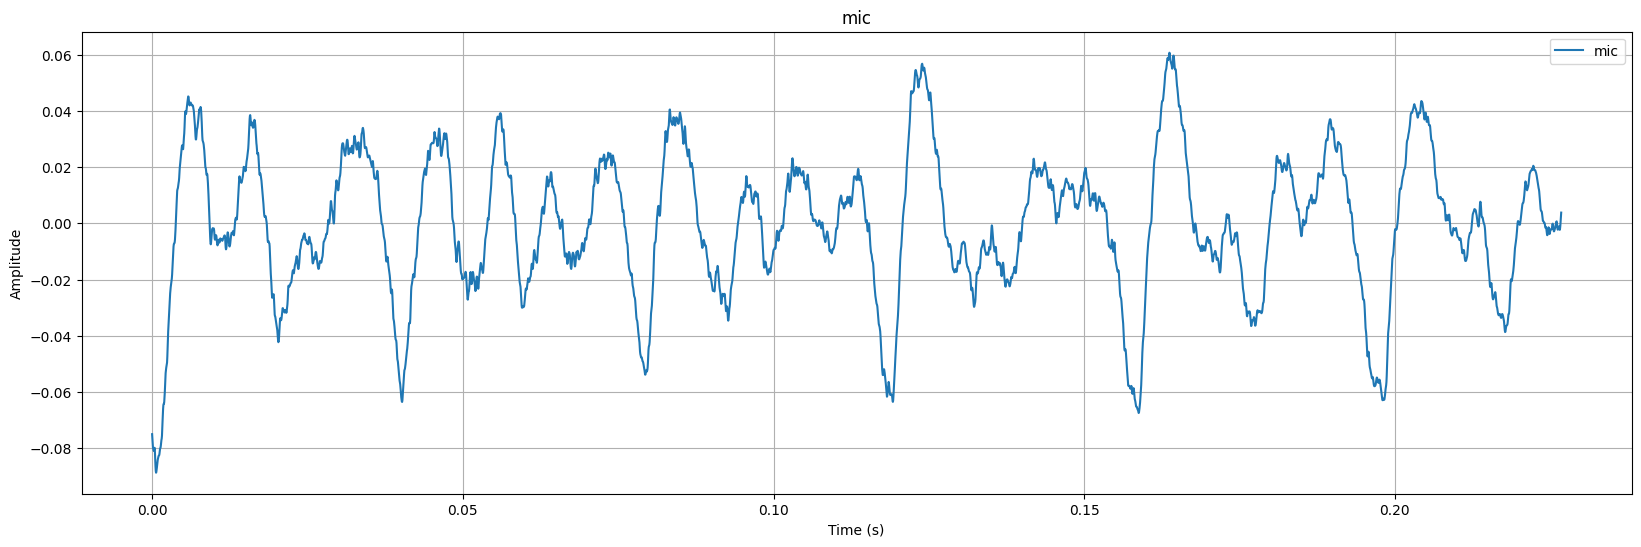

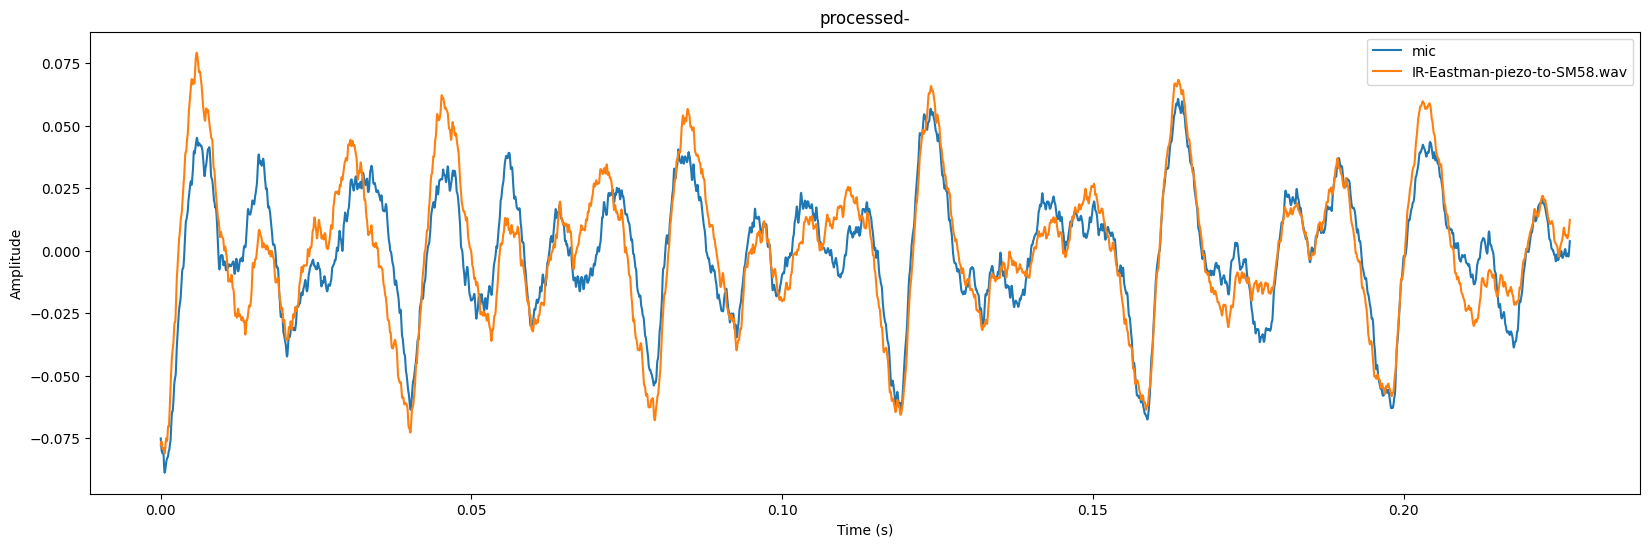

In [298]:
START=30000
LENGTH=5000

plt.figure(figsize=(20, 6))
plot_signal(dry_signal,'piezo', label='piezo', start=START, length=LENGTH)
plt.legend(); plt.figure(figsize=(20, 6))
plot_signal(target_signal,'mic', label='mic', start=START, length=LENGTH)

plt.legend(); plt.figure(figsize=(20, 6))

plot_signal(target_signal,'mic', label='mic', start=START, length=LENGTH)

#plt.legend(); plt.figure(figsize=(20, 6))

IRS = [
  #  'Eastman-piezo-to-SM58-1.wav',
    'IR-Eastman-piezo-to-SM58.wav'
]



for ir_name in IRS:
    # load the impulse response
    impulse_response,ir_sr = librosa.load(ir_name, sr=None)
    sr, ir_sr
    
    processed_signal = apply_impulse_response(dry_signal, impulse_response)
    plot_signal(processed_signal, 'processed-', label=ir_name, start=START, length=LENGTH)
#    plot_signal(impulse_response, 'impulse response')
plt.legend()
plt.show()

In [287]:
[ loudness(s, sr) for s in [dry_signal, target_signal]]

[-29.619186714467855, -28.412892578585605]

In [288]:
[ peak(s) for s in [dry_signal, target_signal]]

[0.24911797, 0.34306479]

In [289]:
[ rms(s) for s in [dry_signal, target_signal]]

[0.036514558, 0.042429946]

In [290]:
[len(s) for s in [dry_signal, target_signal]]

[768000, 768000]

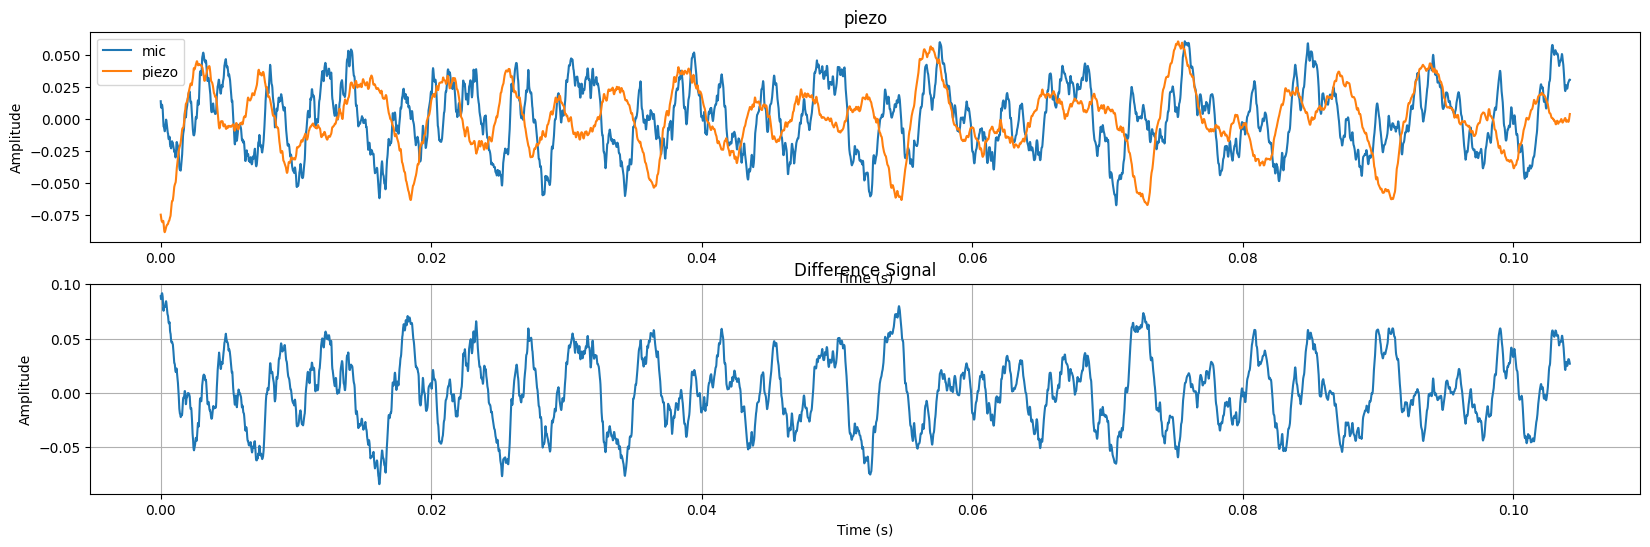

In [295]:
plt.figure(figsize=(20, 6))
compare_signals(dry_signal, target_signal, 'mic', 'piezo', sr, start=START, length=LENGTH)
compare_signals(dry_signal, target_signal, 'mic', 'piezo', sr, start=START, length=LENGTH)

In [82]:
loudness(target_signal, sr)

-28.412892578585605

In [83]:
rms(dry_signal)

0.036514558

In [84]:
rms(normalised(dry_signal, 'loudness', target_signal,sr))

0.041954707

In [127]:
START=25000
SAMPLES=5000
x = dry_signal[START:START+SAMPLES]
y = target_signal[START:START+SAMPLES]


In [129]:
rms_diff = normalised(y, 'rms', x)-x
peak_diff = normalised(y, 'peak',x)-x
loudness_diff = normalised(y, 'peak', x, sr)-x

print(rms(rms_diff), rms(peak_diff), rms(loudness_diff))

0.031920064 0.030235734 0.030235734


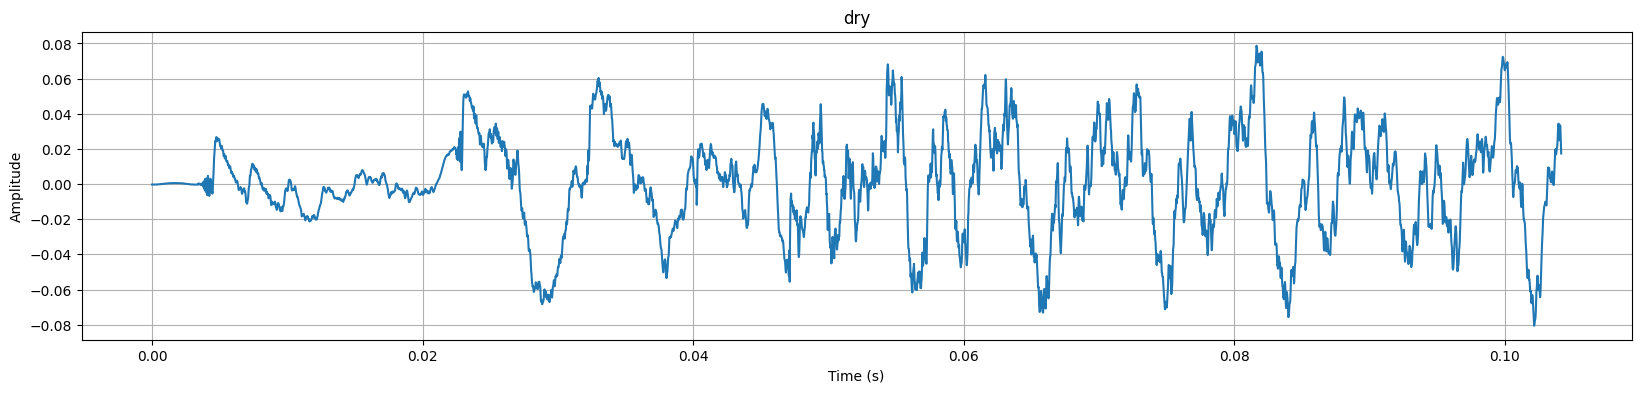

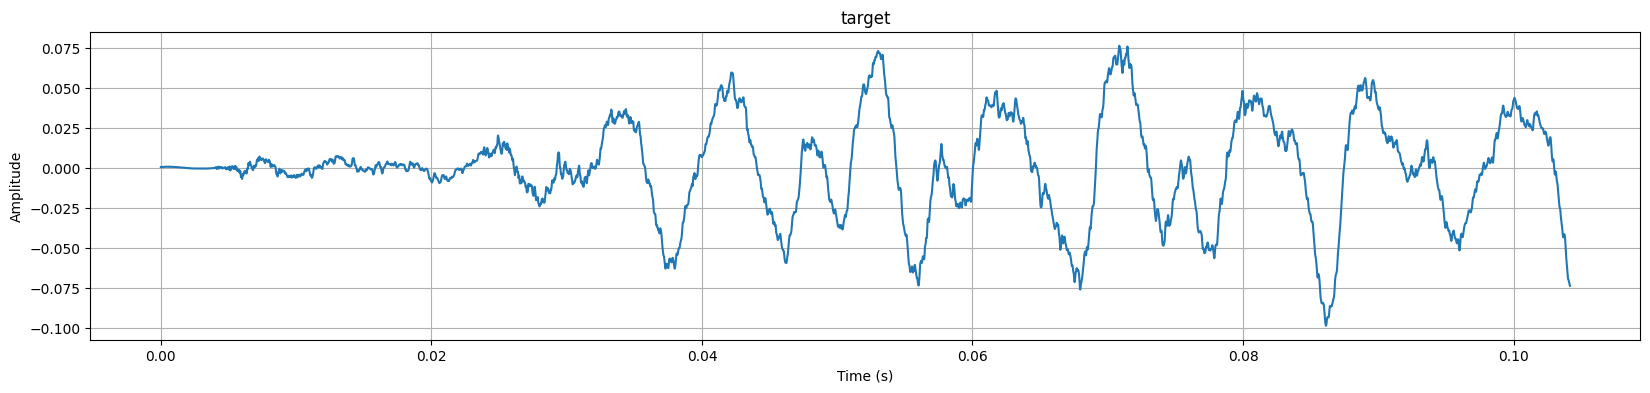

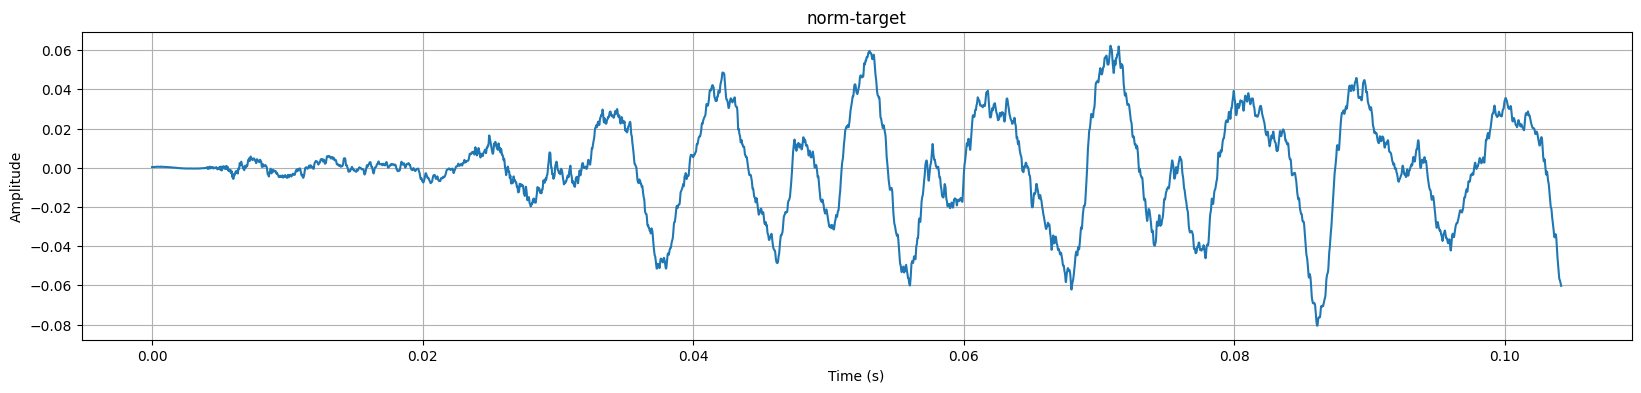

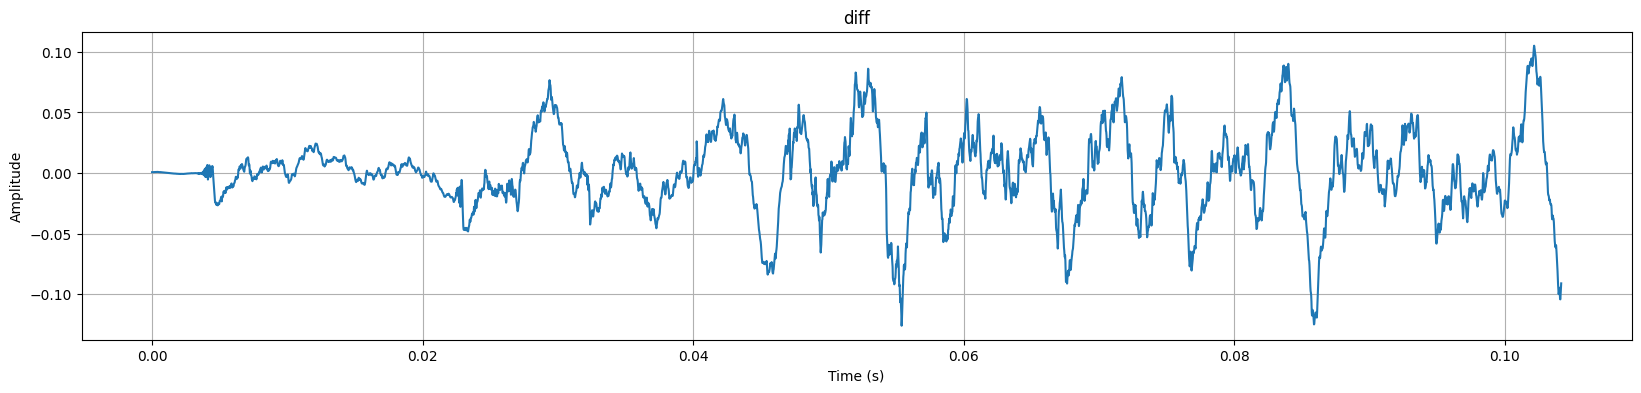

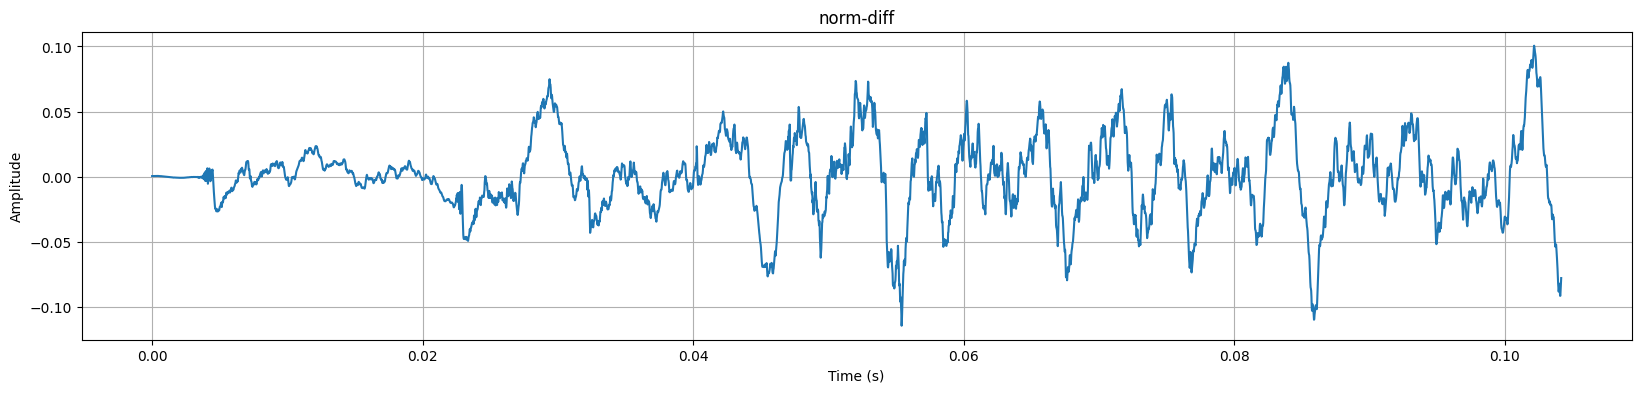

In [131]:
plot_signal(x, 'dry', sr)
plot_signal(y, 'target', sr)
plot_signal(normalised(y, 'peak', x, sr), 'norm-target', sr)
plot_signal(y-x, 'diff', sr)
plot_signal(normalised(y, 'peak', x, sr)-x, 'norm-diff', sr)

In [132]:
len(target_signal)

768000

In [133]:
len(dry_signal)

768000

In [134]:
impulse_response, remainder = deconvolve(target_signal, dry_signal)

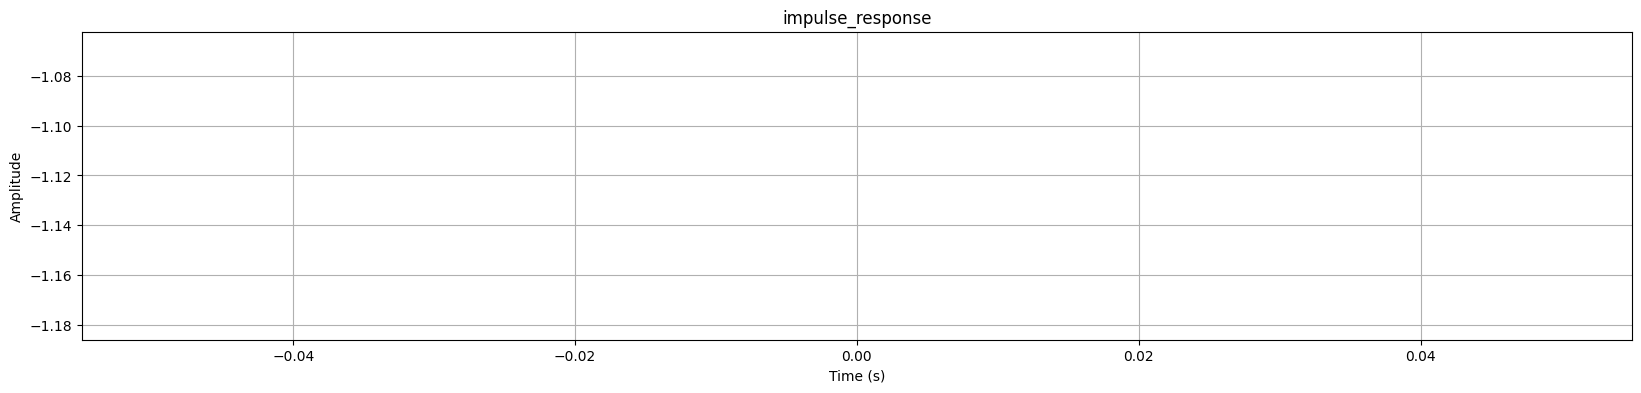

In [135]:
plot_signal(impulse_response, 'impulse_response', sr)

In [136]:
impulse_response

array([-1.12410501])

In [137]:
remainder

array([ 0.00000000e+00,  1.21732885e-05,  1.48391382e-05, ...,
       -4.77499794e-02, -4.60894133e-02, -4.44724995e-02])

In [138]:
len(remainder)

768000

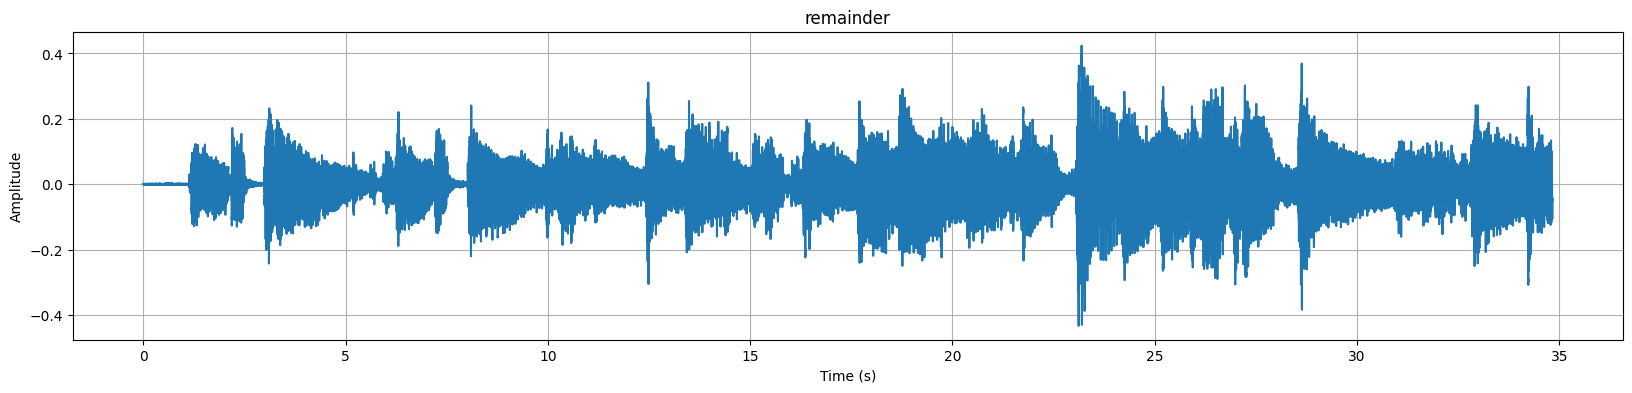

In [139]:
plot_signal(remainder, 'remainder')

In [140]:
deconvolve(x, y)

(array([-0.71816746]),
 array([ 0.00000000e+00, -3.07588592e-05, -3.87629062e-05, ...,
        -2.39850022e-02, -3.07457699e-02, -3.55936000e-02]))

In [141]:
from scipy.fft import fft, ifft

In [168]:
fft_dry = fft(dry_signal)
fft_target = fft(target_signal)
epsilon = 1e-10
impulse_response_fft = fft_target / (fft_dry+epsilon)
impulse_response = np.real(ifft(impulse_response_fft))

In [169]:
impulse_response

array([ 0.00157407, -0.00247113, -0.00991014, ...,  0.00020848,
        0.00337691,  0.00431858], dtype=float32)

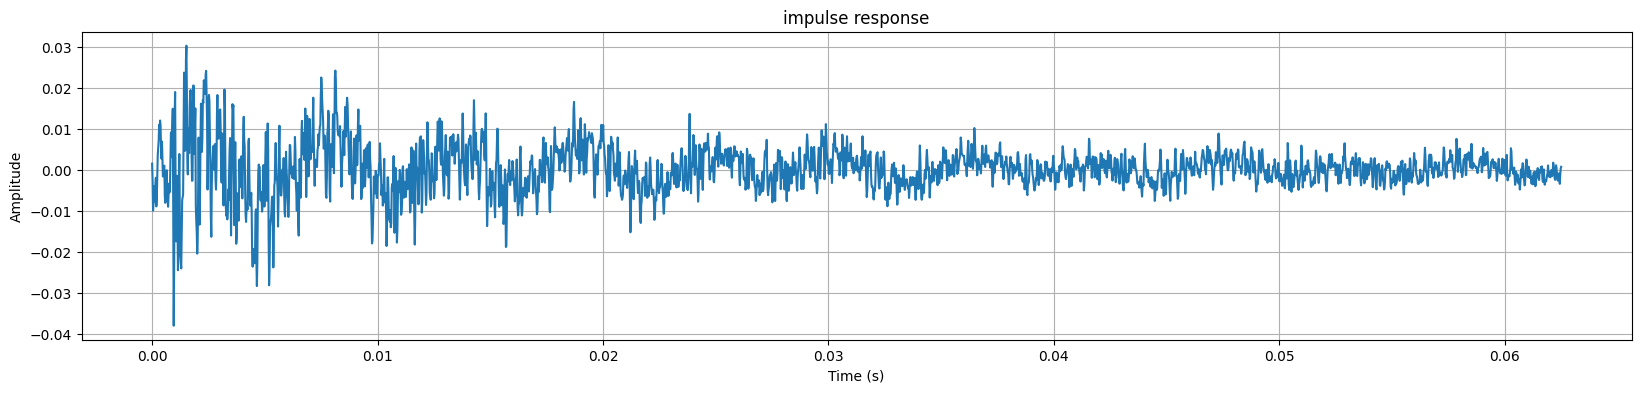

In [180]:
plot_signal(impulse_response[:3000], 'impulse response',sr)

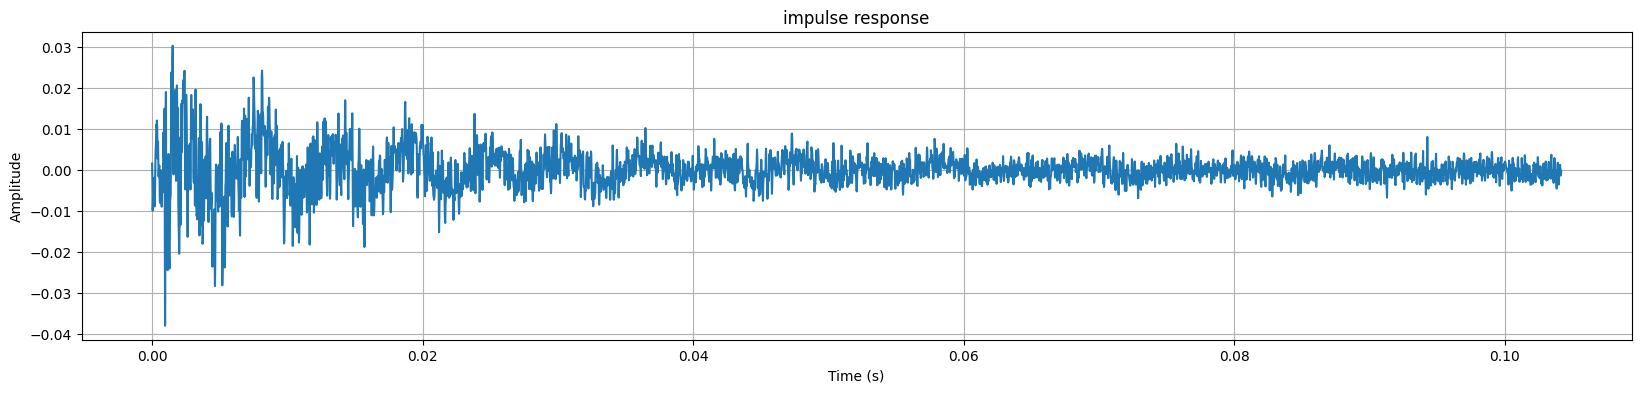

In [181]:
plot_signal(np.real(impulse_response)[0:5000], 'impulse response',sr)

In [243]:
IMPULSE_RESPONSE_LEN=2048
processed_dry = convolve(dry_signal, impulse_response[0:IMPULSE_RESPONSE_LEN])
signal_diff = processed_dry[:len(target_signal)]-target_signal
[rms(s) for s in [dry_signal, target_signal, processed_dry, signal_diff]]

[0.036514558, 0.042429946, 0.037363376, 0.019074185]

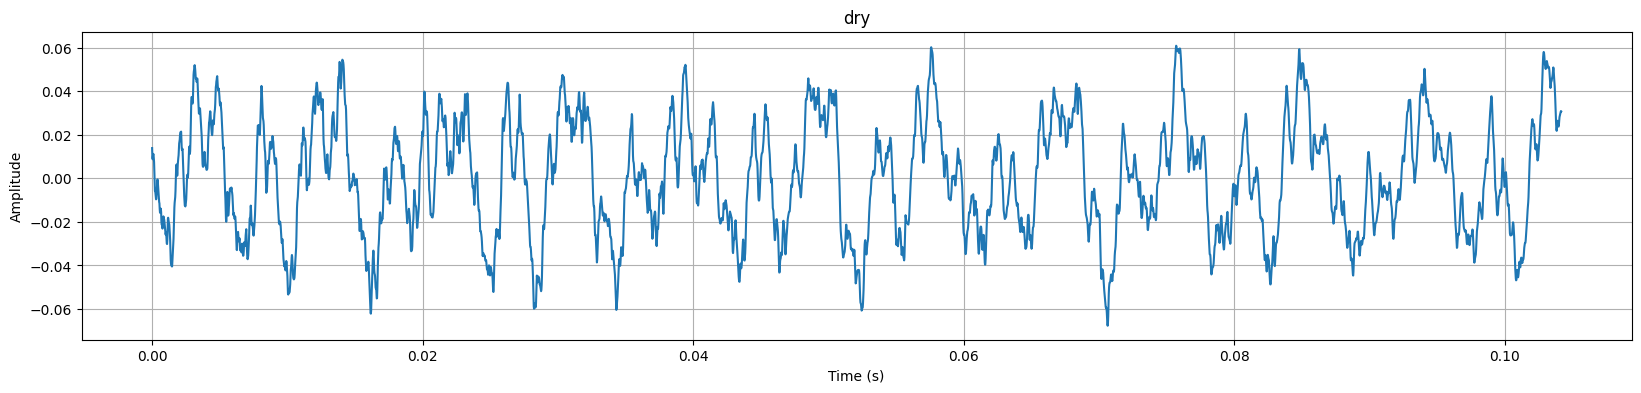

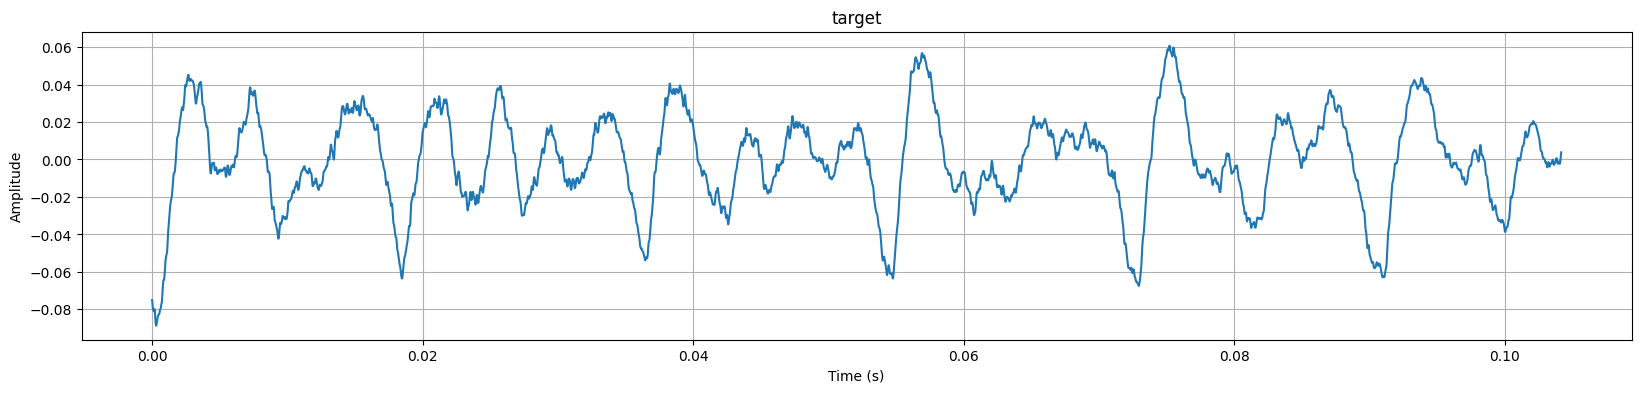

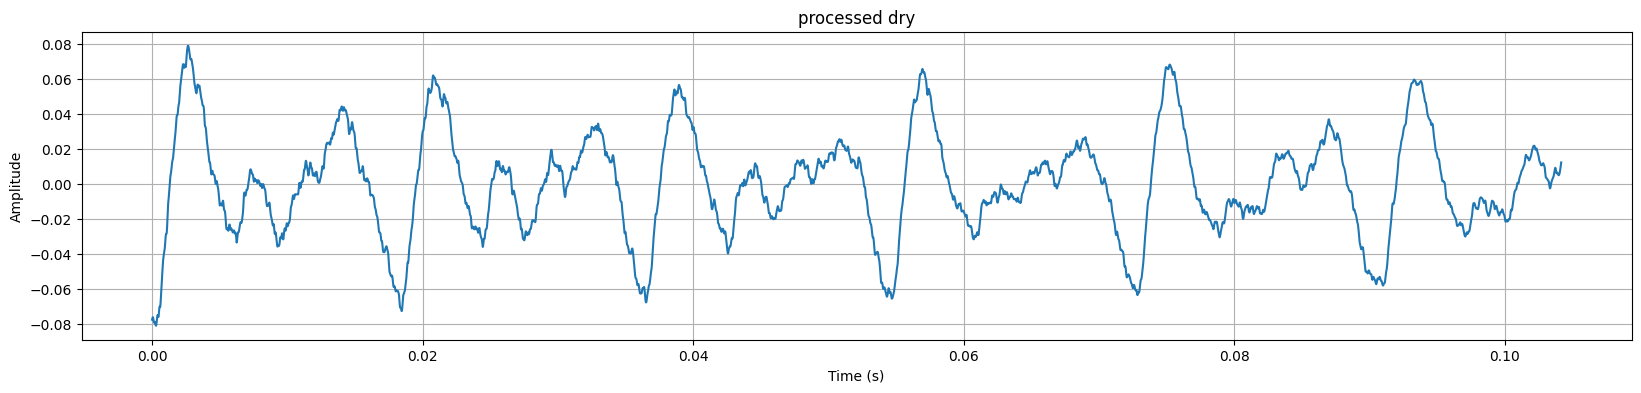

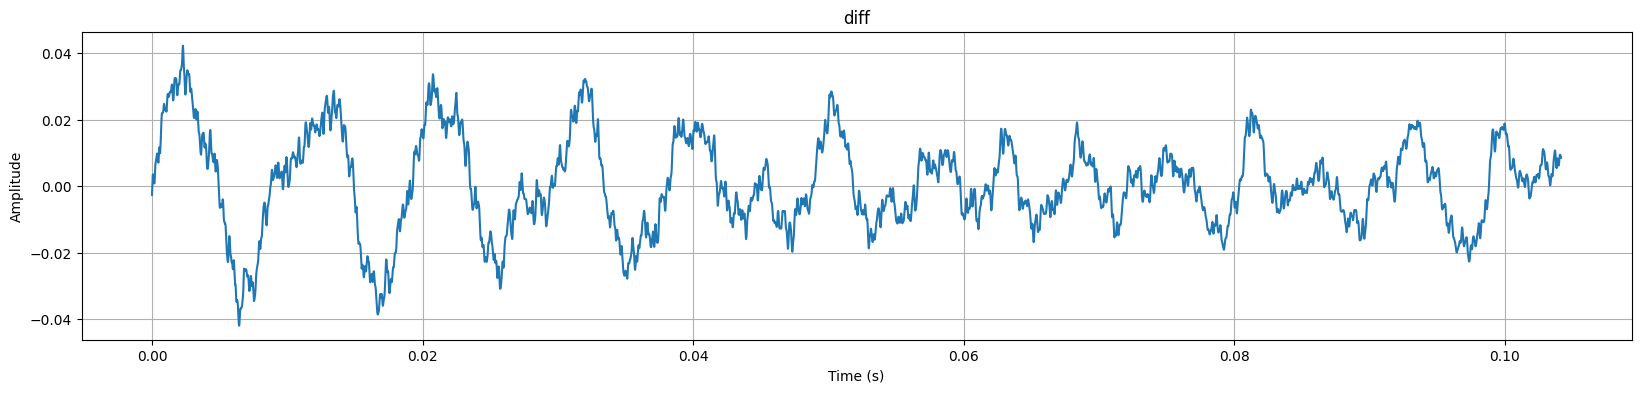

In [244]:
START=30000
LENGTH=5000
plot_signal(dry_signal, 'dry',sr, start=START, length=LENGTH)
plot_signal(target_signal, 'target',sr,start=START, length=LENGTH)
plot_signal(processed_dry, 'processed dry',sr,start=START, length=LENGTH)
plot_signal(signal_diff, 'diff',sr,start=START, length=LENGTH)